<a href="https://colab.research.google.com/github/rashifdhafin/coffeebeans-classification/blob/master/klasifikasi_arabika_robusta2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [ ]:
# Library untuk mengakses Google Drive dan mengakses direktori
from google.colab import drive
import os

# Library untuk membuka dan menyimpan citra
from PIL import Image

# Library untuk menampilkan hasil tiap tahapan pengolahan citra
import matplotlib.pyplot as plt
import random

# Library untuk preprocessing citra
import cv2
import numpy as np

# Library untuk mengekstrak fitur dengan GLCM dan mengubah fitur yang diekstrak
# menjadi dataset
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

# Library untuk klasifikasi
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Input data

Data citra biji kopi arabika dan robusta yang digunakan merupakan citra biji kopi yang diambil menggunakan kamera smartphone Samsung A70 dengan resolusi 32 MP dan rasio 1:1. Hasil citra yang didapat memiliki ukuran gambar 3024x3024 pixel. Citra kemudian di crop untuk menghilangkan bagian yang tidak penting. Cropping citra dilakukan menggunakan aplikasi Photos bawaan Windows. Hasil crop citra memiliki ukuran yang bervariasi

In [ ]:
# Akses ke Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Skripsi/data3/'

/content/drive/MyDrive/Skripsi/data3


In [ ]:
# Path ke folder data
folder_path = '/content/drive/MyDrive/Skripsi/data3/'

# Daftar nama subfolder (Arabica dan Robusta)
subfolders = ['arabica', 'robusta']

# Inisialisasi list untuk citra dan label
cropped_images = []
labels = []

for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    image_names = os.listdir(subfolder_path)
    for image_name in image_names:
        image_path = os.path.join(subfolder_path, image_name)
        cropped_image = Image.open(image_path)
        # Periksa metadata EXIF pada citra dan memeriksa orientasi citra
        # Hal ini diperlukan untuk menghindari orientasi citra yang digunakan
        # berubah tidak seperti posisi citra awal
        exif_data = cropped_image._getexif()
        orientation = 1  # Orientasi default adalah 1 (tidak ada rotasi)

        if exif_data:
            for tag, value in exif_data.items():
                if tag == 274:
                    orientation = value
                    break

        # Menyesuaikan orientasi citra sesuai aslinya apabila orientasi citra
        # berubah
        if orientation in [3, 6, 8]:
            if orientation == 3:
                cropped_image = cropped_image.rotate(180, expand=True)
            elif orientation == 6:
                cropped_image = cropped_image.rotate(270, expand=True)
            elif orientation == 8:
                cropped_image = cropped_image.rotate(90, expand=True)

        # Simpan citra dan label pada array 'cropped_images' dan 'labels'
        cropped_images.append(cropped_image)
        labels.append(subfolder)

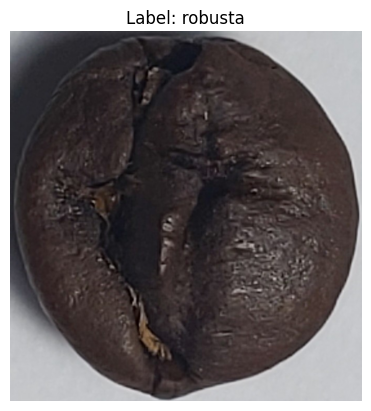

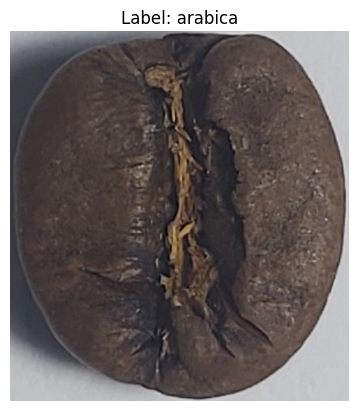

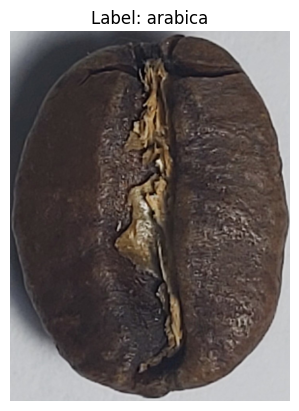

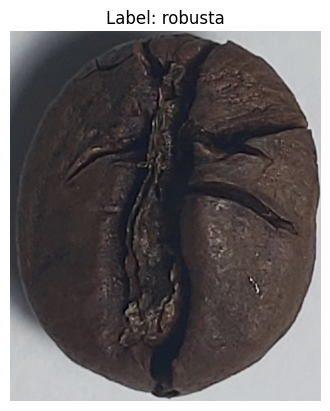

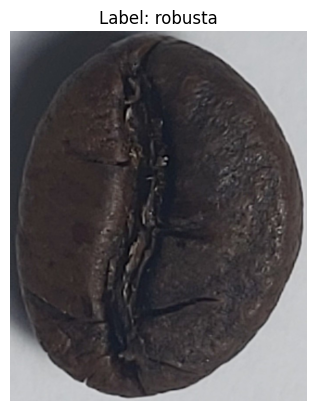

In [ ]:
# Memilih beberapa citra secara acak
num_samples = 5
sample_indices = random.sample(range(len(cropped_images)), num_samples)

# Menampilkan citra beserta labelnya
for i in sample_indices:
    image = cropped_images[i]
    label = labels[i]

    # Menampilkan citra
    plt.figure()
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Preprocessing

## Resize

Pada tahap ini, citra yang telah dicrop kemudian diubah ukurannya menjadi 256x256 pixel untuk menyamakan ukuran dari tiap citra yang telah dicrop

In [ ]:
# Ukuran yang diinginkan
desired_size = (256, 256)

# Inisialisasi list untuk citra baru
resized_images = []

for image in cropped_images:
    # Mengubah citra sesuai ukuran yang diinginkan
    image = image.resize(desired_size)

    # Menambahkan citra yang telah diubah ukurannya ke list baru
    resized_images.append(image)

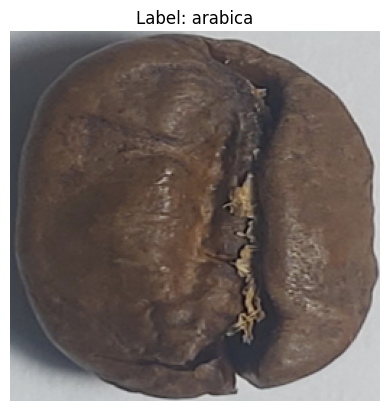

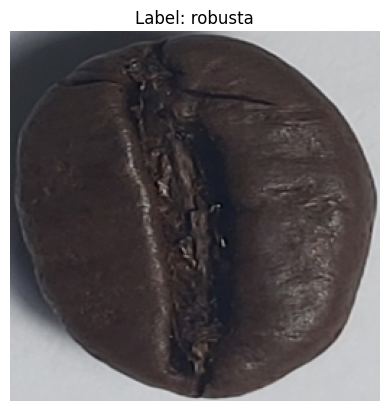

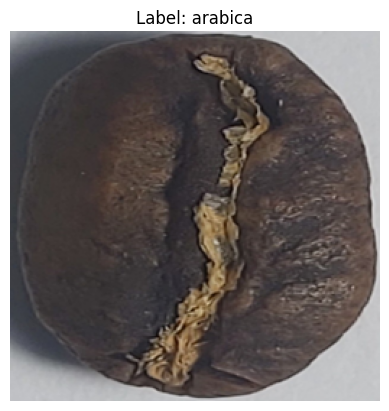

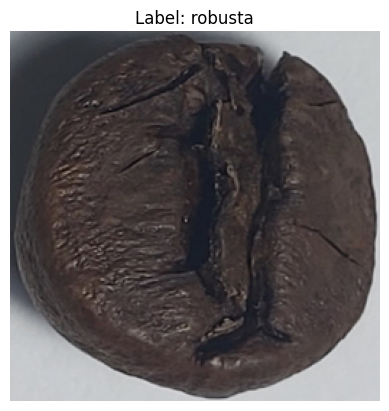

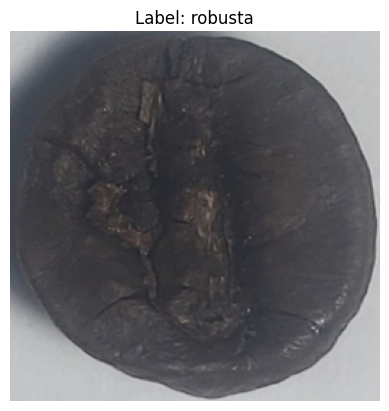

In [ ]:
# Memilih beberapa citra secara acak
num_samples = 5
sample_indices = random.sample(range(len(resized_images)), num_samples)

# Menampilkan citra beserta labelnya
for i in sample_indices:
    image = resized_images[i]
    label = labels[i]

    # Menampilkan citra
    plt.figure()
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

## Grayscale

In [ ]:
# Inisialisasi list untuk citra grayscale
grayscaled_images = []

for image in resized_images:
  # Ubah citra ke dalam format numpy array
  image_np = np.array(image)

  # Ubah citra RGB menjadi Grayscale
  grayscale_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

  # Tambah citra ke dalam list baru
  grayscaled_images.append(Image.fromarray(grayscale_image))

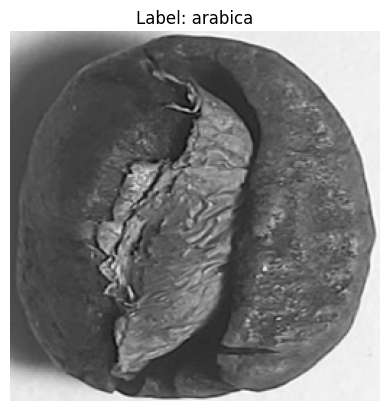

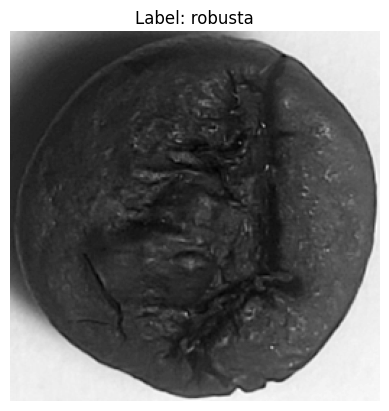

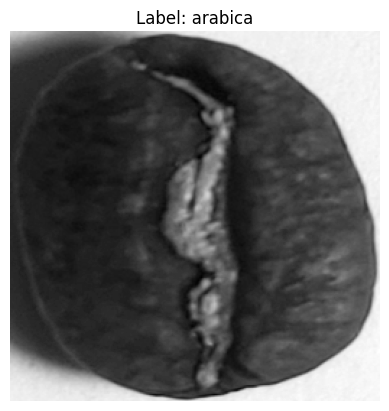

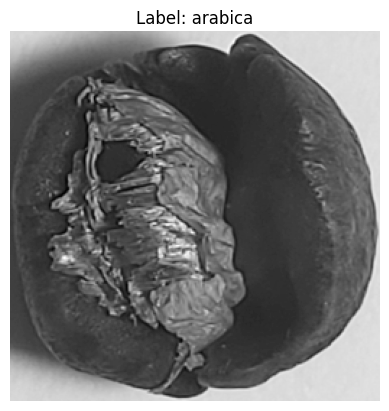

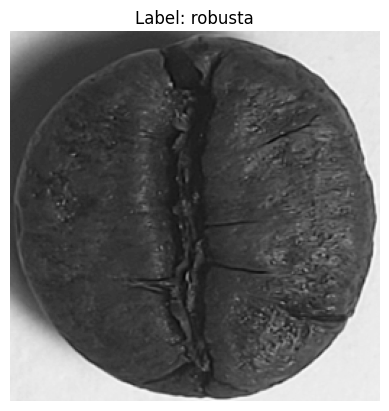

In [ ]:
# Memilih beberapa citra secara acak
num_samples = 5
sample_indices = random.sample(range(len(grayscaled_images)), num_samples)

# Menampilkan citra beserta labelnya
for i in sample_indices:
    image = grayscaled_images[i]
    label = labels[i]

    # Menampilkan citra
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Ekstraksi Fitur

In [ ]:
# Daftar sudut yang ingin dievaluasi (0, 45, 90, 135)
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Inisialisasi list datasets yang menampung dataset yang dihasilkan dari
# ekstraksi fitur dari berbagai sudut
datasets = []

for angle in angles:
  # Inisialisasi dataset kosong yang digunakan untuk menampung hasil ekstraksi
  # fitur GLCM
  # Dataset ini yang akan digunakan pada proses klasifikasi
  feature_df = pd.DataFrame(columns=['Contrast', 'Dissimilarity', 'Homogeneity',
                                     'ASM','Energy', 'Correlation', 'Class'])

  for image, label in zip(grayscaled_images, labels):
    # Ubah citra ke dalam format numpy array
    image_np = np.array(image)

    # Hitung GLCM dengan sudut tertentu
    glcm = graycomatrix(image_np, [1], [angle], symmetric=True, normed=True)

    # Ekstrak fitur dari GLCM
    contrast = graycoprops(glcm, 'contrast')[0,0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    asm = graycoprops(glcm, 'ASM')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]
    correlation = graycoprops(glcm, 'correlation')[0,0]

    # Tambahkan list fitur ke dataset
    feature_df = feature_df.append({'Contrast': contrast,
                                    'Dissimilarity': dissimilarity,
                                    'Homogeneity': homogeneity,
                                    'ASM': asm,
                                    'Energy': energy,
                                    'Correlation': correlation,
                                    'Class': label}, ignore_index=True)

  datasets.append(feature_df)

# Memisahkan dataset hasil ekstraksi fitur GLCM pada datasets sesuai
# sudut yang digunakan
dataset_glcm_0, dataset_glcm_45, dataset_glcm_90, dataset_glcm_135 = datasets

<ipython-input-10-fe571f16d236>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'Contrast': contrast,
<ipython-input-10-fe571f16d236>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'Contrast': contrast,
<ipython-input-10-fe571f16d236>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'Contrast': contrast,
<ipython-input-10-fe571f16d236>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append({'Contrast': contrast,
<ipython-input-10-fe571f16d236>:31: FutureWarning: The frame.append method is deprecated and will be

Lihat hasil ekstraksi fitur

In [ ]:
dataset_glcm_0.head()

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation,Class
0,82.702956,4.029733,0.404953,0.003774,0.061429,0.979878,arabica
1,107.820818,5.017724,0.330082,0.001818,0.042644,0.973612,arabica
2,94.495925,4.319975,0.353491,0.001717,0.041437,0.973458,arabica
3,78.906648,4.230637,0.342232,0.001568,0.039595,0.978520,arabica
4,81.148131,4.238143,0.355942,0.001748,0.041811,0.980375,arabica


In [ ]:
dataset_glcm_45.head()

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation,Class
0,153.847920,5.695456,0.320192,0.002845,0.053339,0.962059,arabica
1,180.600538,6.805721,0.269820,0.001446,0.038026,0.955117,arabica
2,155.835294,5.857778,0.279598,0.001311,0.036206,0.955557,arabica
3,145.496009,5.962937,0.266557,0.001175,0.034282,0.959761,arabica
4,162.129842,6.155832,0.280405,0.001332,0.036500,0.960300,arabica


In [ ]:
dataset_glcm_90.head()

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation,Class
0,82.903600,4.125230,0.376381,0.003523,0.059352,0.979747,arabica
1,124.167433,5.540349,0.309312,0.001782,0.042212,0.969455,arabica
2,92.229320,4.508670,0.328679,0.001671,0.040881,0.973978,arabica
3,98.117708,4.727757,0.316875,0.001483,0.038512,0.973152,arabica
4,105.934298,4.862454,0.332649,0.001701,0.041238,0.974285,arabica


In [ ]:
dataset_glcm_135.head()

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation,Class
0,145.814225,5.454794,0.333052,0.002948,0.054298,0.964040,arabica
1,223.188804,7.430711,0.262896,0.001450,0.038082,0.944534,arabica
2,175.211934,6.143145,0.278345,0.001339,0.036593,0.950032,arabica
3,165.461730,6.196432,0.265288,0.001179,0.034331,0.954240,arabica
4,166.767489,6.135948,0.288627,0.001399,0.037406,0.959165,arabica


In [ ]:
# Impor hasil ekstraksi ke excel
dataset_glcm_0.to_excel('dataset_glcm_0.xlsx', index=True)
dataset_glcm_45.to_excel('dataset_glcm_45.xlsx', index=True)
dataset_glcm_90.to_excel('dataset_glcm_90.xlsx', index=True)
dataset_glcm_135.to_excel('dataset_glcm_135.xlsx', index=True)

# Pemisahan Data Latih dan Data Uji

In [ ]:
# Pisahkan atribut dan kelas pada tiap hasil ekstraksi fitur
X_0 = dataset_glcm_0.drop('Class', axis=1)
y_0 = dataset_glcm_0['Class']

X_45 = dataset_glcm_45.drop('Class', axis=1)
y_45 = dataset_glcm_45['Class']

X_90 = dataset_glcm_90.drop('Class', axis=1)
y_90 = dataset_glcm_90['Class']

X_135 = dataset_glcm_135.drop('Class', axis=1)
y_135 = dataset_glcm_135['Class']

# Bagi data menjadi data latih dan data uji
# Persentase pembagian yang digunakan adalah 80% data latih dan 20% data uji
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_45, X_test_45, y_train_45, y_test_45 = train_test_split(X_45, y_45, test_size=0.2, random_state=42)
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90, y_90, test_size=0.2, random_state=42)
X_train_135, X_test_135, y_train_135, y_test_135 = train_test_split(X_135, y_135, test_size=0.2, random_state=42)

Lihat data latih

In [ ]:
X_train_0.head(10)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
79,71.498009,4.030668,0.348337,0.001687,0.041077,0.980793
197,129.988327,5.784896,0.316067,0.001764,0.041998,0.981160
38,106.384329,4.943857,0.330115,0.001651,0.040632,0.973692
24,88.904672,4.450169,0.345919,0.001441,0.037957,0.979665
122,89.962577,4.466131,0.343267,0.001875,0.043306,0.984908
195,42.063480,3.053922,0.404325,0.001818,0.042639,0.991331
29,78.918612,4.110003,0.375891,0.002355,0.048527,0.981672
19,73.382613,4.043398,0.355349,0.001939,0.044032,0.981333
143,80.149127,4.138373,0.373107,0.001935,0.043987,0.986168
86,151.307950,6.150291,0.318457,0.002000,0.044722,0.965294


In [ ]:
y_train_0.head(10)

79     arabica
197    robusta
38     arabica
24     arabica
122    robusta
195    robusta
29     arabica
19     arabica
143    robusta
86     arabica
Name: Class, dtype: object

Simpan Data Latih yang ke excel

In [ ]:
X_train_0.to_excel('datalatih_glcm_0.xlsx', index=True)
y_train_0.to_excel('label_datalatih_glcm_0.xlsx', index=True)

Lihat data uji

In [ ]:
X_test_0.head(5)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
95,116.252221,5.287760,0.324096,0.001712,0.041378,0.975839
15,130.944516,6.238480,0.257197,0.000934,0.030558,0.963927
30,91.554534,4.741146,0.308818,0.001150,0.033910,0.978391
158,34.597135,2.571461,0.435693,0.002399,0.048977,0.992397
128,95.440273,4.826547,0.321117,0.001820,0.042656,0.986519


In [ ]:
y_test_0.head(5)

95     arabica
15     arabica
30     arabica
158    robusta
128    robusta
Name: Class, dtype: object

Simpan Data Uji ke Excel

In [ ]:
X_test_0.to_excel('datauji_glcm_0.xlsx', index=True)
y_test_0.to_excel('label_datauji_glcm_0.xlsx', index=True)

# Klasifikasi Random Forest

## Skenario 1

Klasifikasi menggunakan empat nilai sudut yang berbeda untuk ekstraksi fitur GLCM dengan jarak ketetanggaan 1 piksel dan 100 pohon keputusan Random Forest. Sudut yang digunakan antara lain 0°, 45°, 90°, dan 135°. Skenario ini dilakukan untuk mengetahui pengaruh nilai sudut yang digunakan pada ekstraksi fitur dengan GLCM terhadap hasil klasifikasi.

In [ ]:
# Inisialisasi model Random Forest menggunakan 100 pohon keputusan
rf_classifier_0 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_45 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_90 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_135 = RandomForestClassifier(n_estimators=100, random_state=42)

# Proses pelatihan model
rf_classifier_0.fit(X_train_0, y_train_0)
rf_classifier_45.fit(X_train_45, y_train_45)
rf_classifier_90.fit(X_train_90, y_train_90)
rf_classifier_135.fit(X_train_135, y_train_135)

# Proses pengujian model
classifications_0 = rf_classifier_0.predict(X_test_0)
classifications_45 = rf_classifier_45.predict(X_test_45)
classifications_90 = rf_classifier_90.predict(X_test_90)
classifications_135 = rf_classifier_135.predict(X_test_135)

In [ ]:
# Lihat hasil akurasi
accuracy_0 = accuracy_score(y_test_0, classifications_0)
accuracy_45 = accuracy_score(y_test_45, classifications_45)
accuracy_90 = accuracy_score(y_test_90, classifications_90)
accuracy_135 = accuracy_score(y_test_135, classifications_135)

print('Akurasi klasifikasi dari dataset GLCM pada sudut 0: ', accuracy_0)
print('Akurasi klasifikasi dari dataset GLCM pada sudut 45: ', accuracy_45)
print('Akurasi klasifikasi dari dataset GLCM pada sudut 90: ', accuracy_90)
print('Akurasi klasifikasi dari dataset GLCM pada sudut 135: ', accuracy_135)

Akurasi klasifikasi dari dataset GLCM pada sudut 0:  0.925
Akurasi klasifikasi dari dataset GLCM pada sudut 45:  0.9
Akurasi klasifikasi dari dataset GLCM pada sudut 90:  0.9
Akurasi klasifikasi dari dataset GLCM pada sudut 135:  0.9


## Skenario 2

Klasifikasi menggunakan hasil ekstraksi fitur GLCM yang memiliki nilai akurasi klasifikasi tertinggi pada skenario pertama dan jumlah pohon keputusan Random Forest yang berbeda. Jumlah pohon keputusan Random Forest yang digunakan antara lain 50, 100, 150, dan 200. Skenario ini dilakukan untuk mengetahui pengaruh jumlah pohon keputusan Random Forest yang digunakan terhadap hasil klasifikasi.

In [ ]:
# Inisialisasi model Random Forest menggunakan 50, 150, dan 200 pohon keputusan
rf_classifier_50_tree = RandomForestClassifier(n_estimators=50, random_state=42)
rf_classifier_150_tree = RandomForestClassifier(n_estimators=150, random_state=42)
rf_classifier_200_tree = RandomForestClassifier(n_estimators=200, random_state=42)

# Proses pelatihan model
rf_classifier_50_tree.fit(X_train_0, y_train_0)
rf_classifier_150_tree.fit(X_train_0, y_train_0)
rf_classifier_200_tree.fit(X_train_0, y_train_0)

# Proses pengujian model
classifications_50_tree = rf_classifier_50_tree.predict(X_test_0)
classifications_150_tree = rf_classifier_150_tree.predict(X_test_0)
classifications_200_tree = rf_classifier_200_tree.predict(X_test_0)

In [ ]:
# Lihat hasil akurasi
accuracy_50_tree = accuracy_score(y_test_0, classifications_50_tree)
accuracy_100_tree = accuracy_0 # Mengambil hasil pada skenario 1
accuracy_150_tree = accuracy_score(y_test_0, classifications_150_tree)
accuracy_200_tree = accuracy_score(y_test_0, classifications_200_tree)

print('Akurasi klasifikasi Random Forest dengan 50 pohon: ', accuracy_50_tree)
print('Akurasi klasifikasi Random Forest dengan 100 pohon: ', accuracy_100_tree)
print('Akurasi klasifikasi Random Forest dengan 150 pohon: ', accuracy_150_tree)
print('Akurasi klasifikasi Random Forest dengan 200 pohon: ', accuracy_200_tree)

Akurasi klasifikasi Random Forest dengan 50 pohon:  0.925
Akurasi klasifikasi Random Forest dengan 100 pohon:  0.925
Akurasi klasifikasi Random Forest dengan 150 pohon:  0.925
Akurasi klasifikasi Random Forest dengan 200 pohon:  0.925


## Feature Importance

In [ ]:
# Lihat nilai Feature Importance
feature_importance = rf_classifier_0.feature_importances_
print(feature_importance)

[0.18240388 0.13326729 0.08381434 0.07018993 0.05494621 0.47537835]


Grafik dari feature importance

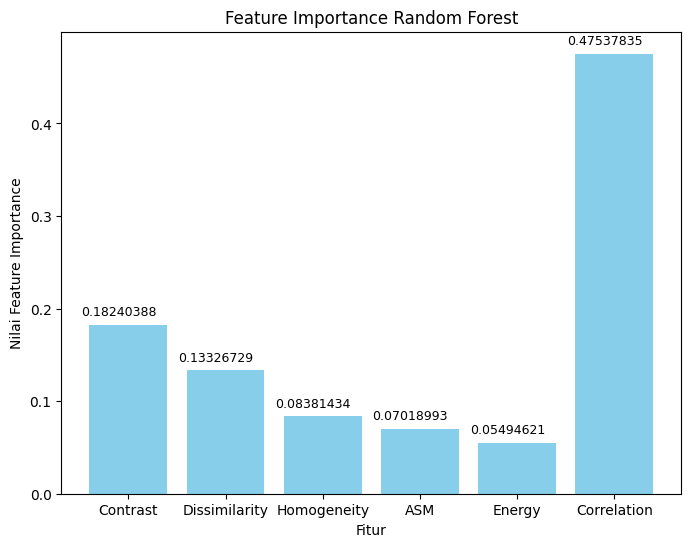

In [ ]:
# Daftar fitur
features = ['Contrast', 'Dissimilarity', 'Homogeneity', 'ASM', 'Energy', 'Correlation']

# Membuat grafik
plt.figure(figsize=(8, 6))
bars = plt.bar(features, feature_importance, color='skyblue')
plt.xlabel('Fitur')
plt.ylabel('Nilai Feature Importance')
plt.title('Feature Importance Random Forest')
# Menambahkan angka detail untuk setiap bar fitur
for bar, imp in zip(bars, feature_importance):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{imp:.8f}', ha='center', color='black', fontsize=9)
plt.show()

# Evaluasi Hasil

Text(0.5, 1.0, 'Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 100 Pohon Keputusan Random Forest\n')

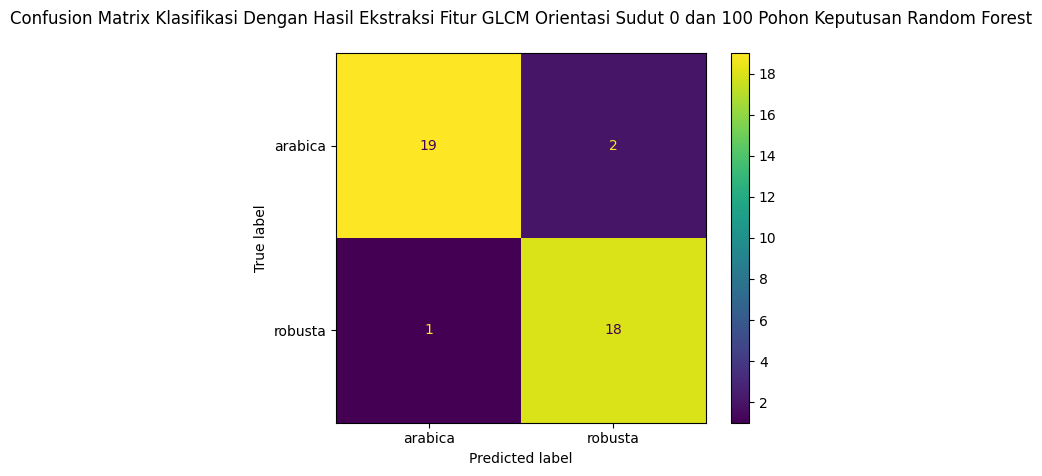

In [ ]:
confusion_matrix_0 = confusion_matrix(y_test_0, classifications_0)
confusion_matrix_display_0 = ConfusionMatrixDisplay(confusion_matrix_0, display_labels=["arabica", "robusta"])

# Tampilkan Confusion Matrix
confusion_matrix_display_0.plot()
confusion_matrix_display_0.ax_.set_title("Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 100 Pohon Keputusan Random Forest\n")

Text(0.5, 1.0, 'Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 50 Pohon Keputusan Random Forest\n')

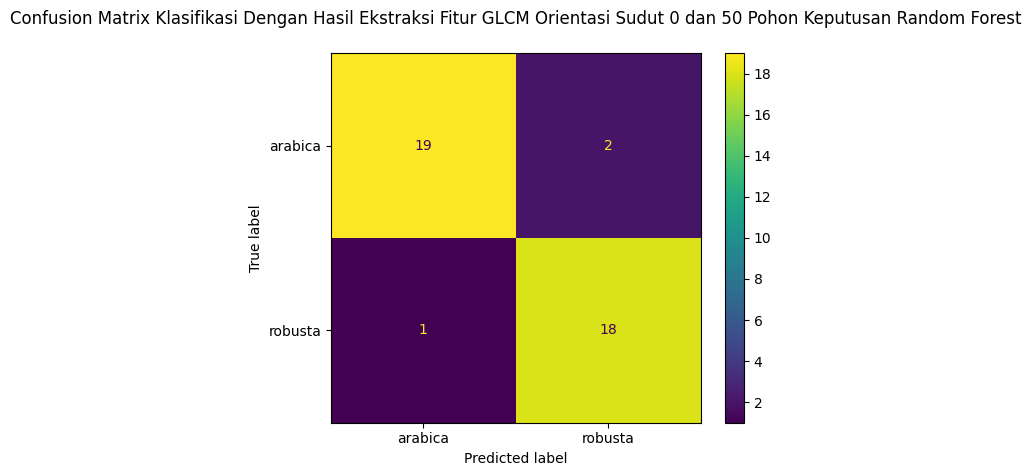

In [ ]:
confusion_matrix_50_tree = confusion_matrix(y_test_0, classifications_50_tree)
confusion_matrix_50_tree_display = ConfusionMatrixDisplay(confusion_matrix_50_tree, display_labels=["arabica", "robusta"])

# Tampilkan Confusion Matrix
confusion_matrix_50_tree_display.plot()
confusion_matrix_50_tree_display.ax_.set_title("Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 50 Pohon Keputusan Random Forest\n")

Text(0.5, 1.0, 'Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 150 Pohon Keputusan Random Forest\n')

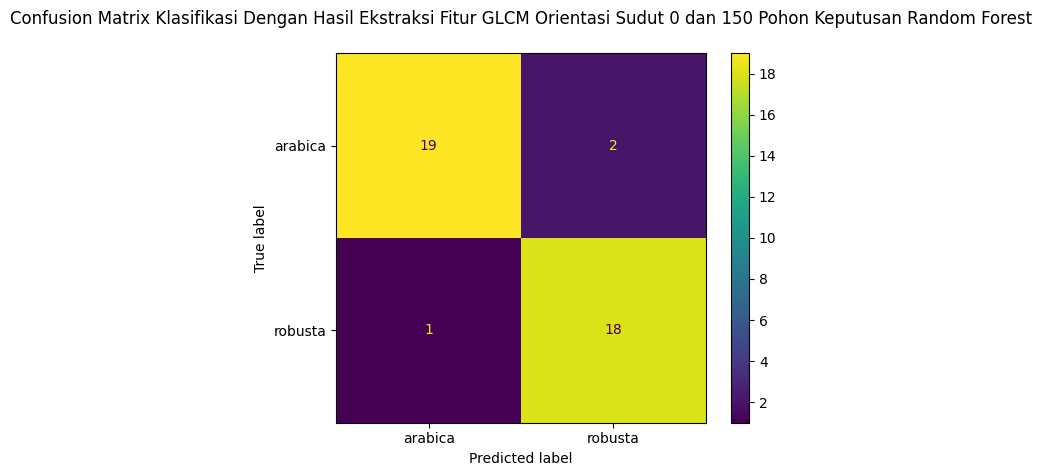

In [ ]:
confusion_matrix_150_tree = confusion_matrix(y_test_0, classifications_150_tree)
confusion_matrix_150_tree_display = ConfusionMatrixDisplay(confusion_matrix_150_tree, display_labels=["arabica", "robusta"])

# Tampilkan Confusion Matrix
confusion_matrix_150_tree_display.plot()
confusion_matrix_150_tree_display.ax_.set_title("Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 150 Pohon Keputusan Random Forest\n")

Text(0.5, 1.0, 'Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 200 Pohon Keputusan Random Forest\n')

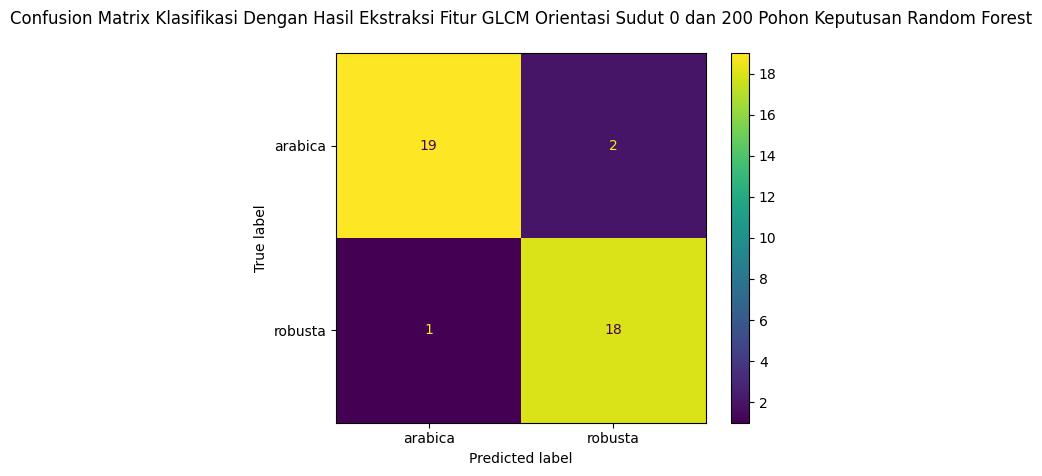

In [ ]:
confusion_matrix_200_tree = confusion_matrix(y_test_0, classifications_200_tree)
confusion_matrix_200_tree_display = ConfusionMatrixDisplay(confusion_matrix_200_tree, display_labels=["arabica", "robusta"])

# Tampilkan Confusion Matrix
confusion_matrix_200_tree_display.plot()
confusion_matrix_200_tree_display.ax_.set_title("Confusion Matrix Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 200 Pohon Keputusan Random Forest\n")

In [ ]:
classification_report_0 = classification_report(y_test_0, classifications_0)
print('Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 100 Pohon Keputusan Random Forest:\n', classification_report_0)

Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 100 Pohon Keputusan Random Forest:
               precision    recall  f1-score   support

     arabica       0.95      0.90      0.93        21
     robusta       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [ ]:
classification_report_50_tree = classification_report(y_test_0, classifications_50_tree)
print('Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 50 Pohon Keputusan Random Forest:\n', classification_report_50_tree)

Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 50 Pohon Keputusan Random Forest:
               precision    recall  f1-score   support

     arabica       0.95      0.90      0.93        21
     robusta       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [ ]:
classification_report_150_tree = classification_report(y_test_0, classifications_150_tree)
print('Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 150 Pohon Keputusan Random Forest:\n', classification_report_150_tree)

Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 150 Pohon Keputusan Random Forest:
               precision    recall  f1-score   support

     arabica       0.95      0.90      0.93        21
     robusta       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [ ]:
classification_report_200_tree = classification_report(y_test_0, classifications_200_tree)
print('Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 200 Pohon Keputusan Random Forest:\n', classification_report_200_tree)

Laporan Klasifikasi Dengan Hasil Ekstraksi Fitur GLCM Orientasi Sudut 0 dan 200 Pohon Keputusan Random Forest:
               precision    recall  f1-score   support

     arabica       0.95      0.90      0.93        21
     robusta       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [ ]:
from sklearn.tree import plot_tree

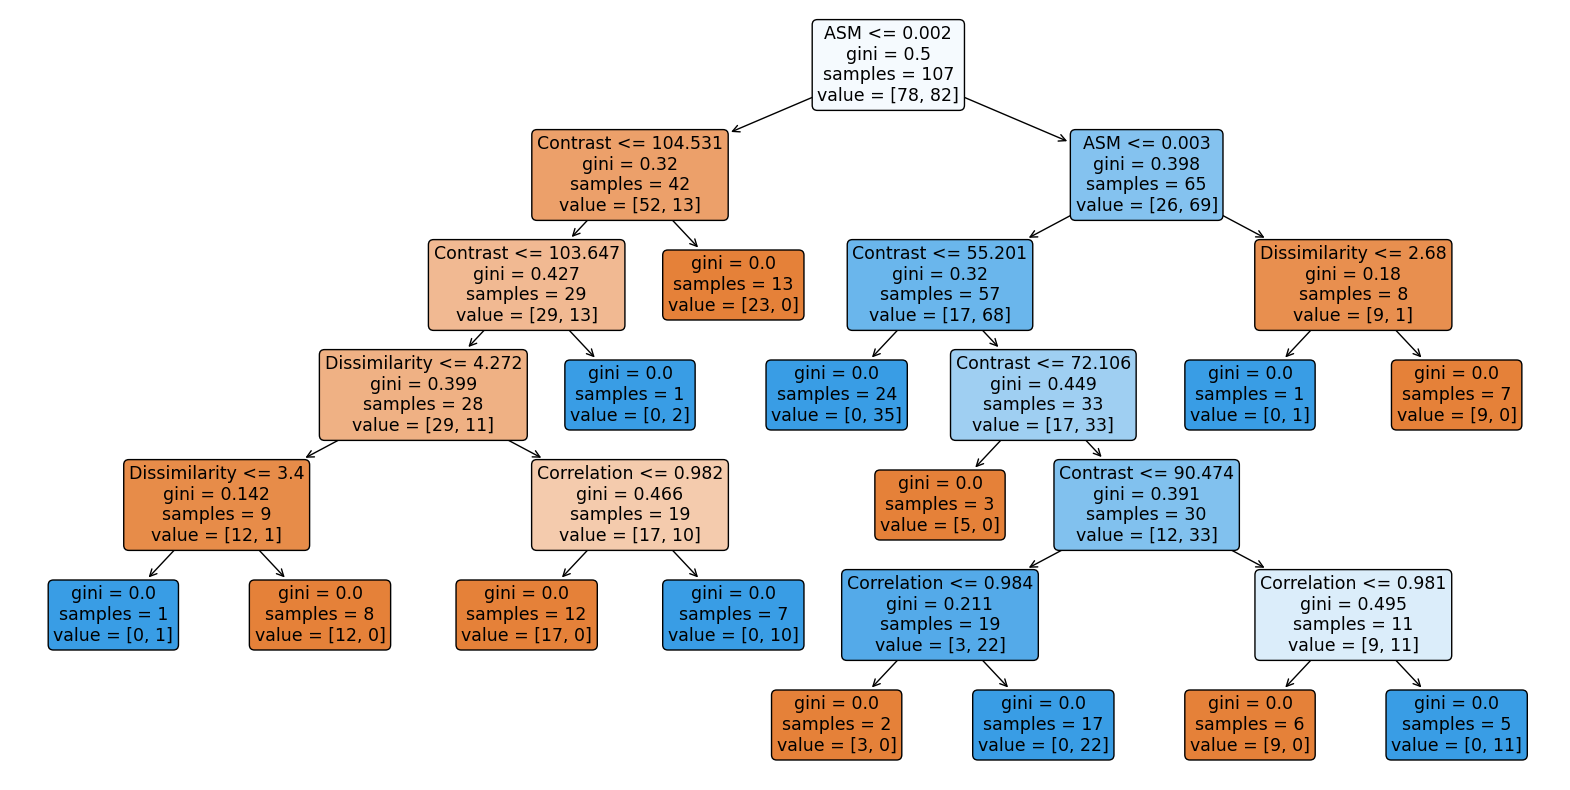

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier_0.estimators_[0], feature_names=X_train_0.columns, filled=True, rounded=True)
plt.show()